In [15]:
import numpy as np
import pandas as pd
from math import sqrt
from pandas import read_csv
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.optimizers import Adam


In [16]:
# data = pd.read_csv('/Users/yashwanthkaruparthi/Documents/Documents1/acad/sem7/design project EEE F337/implement/sample/BiLSTM_solar_weather/solar_weather copy.csv')

data = pd.read_csv('/Users/yashwanthkaruparthi/Documents/Acads/sem7/design project/execution/data/solar_weather.csv', header=0, infer_datetime_format=True, parse_dates=['Time'], index_col=['Time'])

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

/var/folders/n5/mlsmdgns0kqfybw1r9qm4n5w0000gp/T/ipykernel_87483/3825166027.py:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv('/Users/yashwanthkaruparthi/Documents/Acads/sem7/design project/execution/data/solar_weather copy 2.csv', header=0, infer_datetime_format=True, parse_dates=['Time'], index_col=['Time'])


In [17]:
data = data[(data.index.month.isin([6, 7, 8])) & (data.index.year == 2021)]

In [18]:
data['Energy delta[Wh]'].max()

4473

In [19]:
data.shape

(8832, 16)

Steps:
1. Preprocess Data: Convert the "Time" feature to a datetime index, and select the required columns: "Energy delta[Wh]" (dependent variable) and "GHI" (independent variable).
2. Normalize Data: Normalize the dataset to make training more effective.
3. Create Data Sequences: Create sliding windows of data using time steps to feed into the BiLSTM.
4. Train-Test Split: Split the data into training and testing sets.
5. Build BiLSTM Model: Build and compile the BiLSTM model.
6. Train the Model: Train the model using the training data.
7. Evaluate and Predict: Evaluate the model on the test set and make predictions.
8. Plot the Predictions: Plot the predicted vs. actual values.

In [20]:
# Select relevant columns: 'Energy delta[Wh]' and 'GHI'

dataset = data[['Energy delta[Wh]']]

# Normalize the data using MinMaxScaler
# scaler = MinMaxScaler(feature_range=(0, 1))
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(dataset)

# Function to create sequences with time steps
# def create_dataset(dataset, time_step=1):
def create_dataset(dataset, time_step):
    print(f'dataset shape {dataset.shape}')
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step):
        a = dataset[i:(i + time_step), :]  # Features: GHI and Energy delta
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])  # Target: Energy delta
    return np.array(dataX), np.array(dataY)

# X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))  # Adding the feature dimension
# X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Set time_step (lookback window for BiLSTM)
time_step = 24  # Predict based on past 24 hours (1 day)
X, y = create_dataset(scaled_data, time_step)
print(f'X, y shape {X.shape} {y.shape}')
# Split the data into training and testing sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Check the shape of the training and testing sets
X_train.shape, X_test.shape, y_train.shape, y_test.shape


dataset shape (8832, 1)
X, y shape (8808, 24, 1) (8808,)


((7046, 24, 1), (1762, 24, 1), (7046,), (1762,))

In [21]:
def plot_learning_curve(history, model_name):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(loss) + 1)

  plt.figure(figsize=(10,6))
  plt.plot(epochs, loss, 'b-', label='Training Loss')
  plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
  plt.title(f'Learning curve: {model_name}')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout

learning_rate = 0.001  # Example learning rate

# Create the optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)

# Build the BiLSTM model
model = Sequential()
model.add(Bidirectional(LSTM(250, activation='relu', return_sequences=True, input_shape=(time_step, 5))))
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(250, activation='relu', return_sequences=False)))
model.add(Dropout(0.2))

model.add(Dense(1))  
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), verbose=1)

# Evaluate the model
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)

train_loss, test_loss


Epoch 1/10
111/111 [==============================] - 35s 292ms/step - loss: 0.0135 - val_loss: 0.0076
Epoch 2/10
 60/111 [===============>..............] - ETA: 16s - loss: 0.0071

KeyboardInterrupt: 

## inverse scale (convert back to original values) for model evaluation

In [ ]:
# Make predictions using the test data
y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)

def inverse_scale_two_variables(scaler, y_pred, X_train):
  # Inverse transform the predictions and actual values to the original scale
    y_train_predict = scaler.inverse_transform(np.concatenate((y_train_predict, X_train[:, -1, 1].reshape(-1, 1)), axis=1))[:, 0]

    y_test_predict = scaler.inverse_transform(np.concatenate((y_test_predict, X_test[:, -1, 1].reshape(-1, 1)), axis=1))[:, 0]

    y_train_actual = scaler.inverse_transform(np.concatenate((y_train.reshape(-1, 1), X_train[:, -1, 1].reshape(-1, 1)), axis=1))[:, 0]

    y_test_actual = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), X_test[:, -1, 1].reshape(-1, 1)), axis=1))[:, 0]


def inverse_scale_four_variables(scaler, y_pred, X_train):
    y_train_predict = scaler.inverse_transform(
        np.concatenate([y_train_predict, X_train[:, -1, 1:]], axis=1)
    )[:, 0]

    y_test_predict = scaler.inverse_transform(
        np.concatenate([y_test_predict, X_test[:, -1, 1:]], axis=1)
    )[:, 0]

    y_train_actual = scaler.inverse_transform(
        np.concatenate([y_train.reshape(-1, 1), X_train[:, -1, 1:]], axis=1)
    )[:, 0]

    y_test_actual = scaler.inverse_transform(
        np.concatenate([y_test.reshape(-1, 1), X_test[:, -1, 1:]], axis=1)
    )[:, 0]

# Inverse transform the predictions and actual values to the original scale
y_train_predict = scaler.inverse_transform(y_train_predict.reshape(-1, 1))

y_test_predict = scaler.inverse_transform(y_test_predict.reshape(-1, 1))

y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))

y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))


# # Wrapper function to decide which inverse scaling method to use
# def inverse_scale_wrapper(scaler, y_pred, X_train, method='new'):
#     if method == 'old':
#         return inverse_scale_two_variables(scaler, y_pred, X_train)
#     elif method == 'new':
#         return inverse_scale_four_variables(scaler, y_pred, X_train)
#     else:
#         raise ValueError("Unknown method! Use 'old' or 'new'.")

# # Example usage
# # y_train_predict, y_test_predict, X_train, X_test should be defined as per your code logic
# # Assuming a condition to select which method to use based on the number of features

# num_features = X_train.shape[2]  # Check how many features are there in the input data

# # For old method (2 attributes), for new method (>2 attributes)
# if num_features == 2:
#     method = 'old'
# else:
#     method = 'new'

# # Use the wrapper function to get the inverse scaled data
# y_train_actual = inverse_scale_wrapper(scaler, y_train_predict, X_train, method)
# y_test_actual = inverse_scale_wrapper(scaler, y_test_predict, X_test, method)  

56/56 [==============================] - 2s 44ms/step


In [ ]:
evaluation_results = []

def evaluate_model(y_true, y_pred, model_name, dataset_type):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    # Append metrics to evaluation_results
    evaluation_results.append({
        'Model': model_name,
        'Dataset': dataset_type,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2
    })
    
evaluate_model(y_train_actual, y_train_predict, 'Bilstm', 'Training')
evaluate_model(y_test_actual, y_test_predict, 'Bilstm', 'Testing')

In [ ]:
evaluation_results = pd.DataFrame(evaluation_results)
evaluation_results

,Model,Dataset,MAE,MSE,RMSE,R²
0,Bilstm,Training,198.263711,117601.267895,342.930413,0.910727
1,Bilstm,Testing,198.623525,129600.735075,360.001021,0.849104


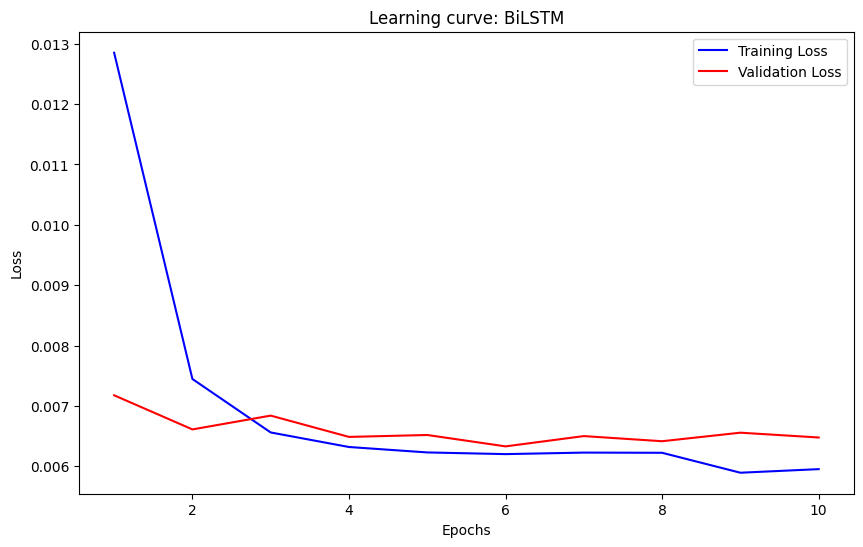

In [ ]:
plot_learning_curve(history, 'BiLSTM')

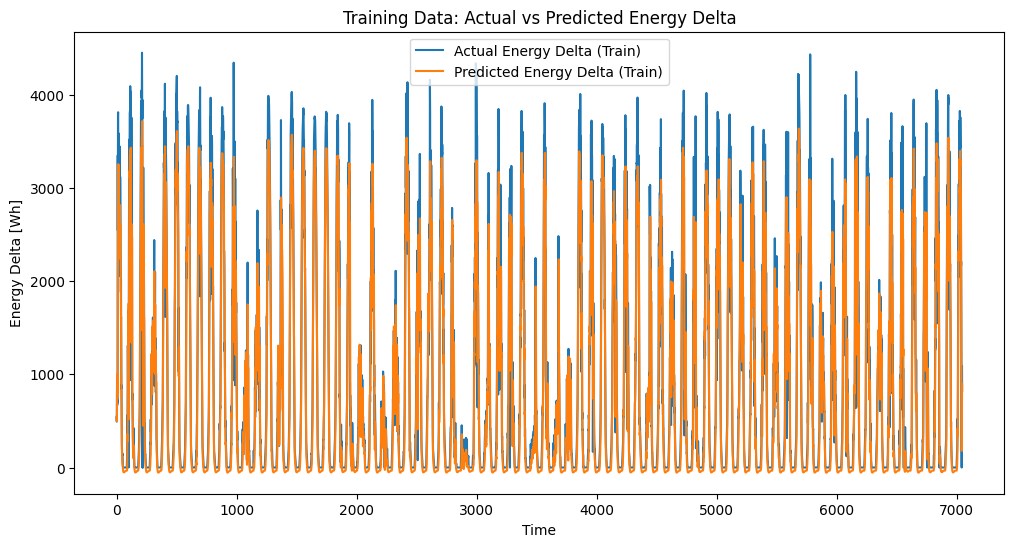

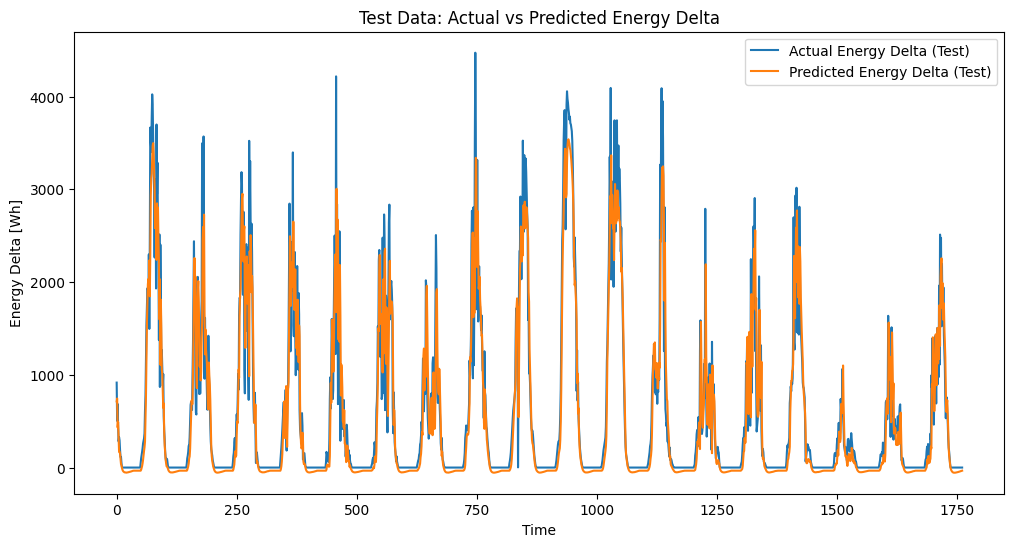

In [ ]:
import matplotlib.pyplot as plt

# Plotting actual vs predicted for training data
plt.figure(figsize=(12, 6))
plt.plot(y_train_actual, label="Actual Energy Delta (Train)")
plt.plot(y_train_predict, label="Predicted Energy Delta (Train)")
plt.title("Training Data: Actual vs Predicted Energy Delta")
plt.xlabel("Time")
plt.ylabel("Energy Delta [Wh]")
plt.legend()
plt.show()

# Plotting actual vs predicted for testing data
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label="Actual Energy Delta (Test)")
plt.plot(y_test_predict, label="Predicted Energy Delta (Test)")
plt.title("Test Data: Actual vs Predicted Energy Delta")
plt.xlabel("Time")
plt.ylabel("Energy Delta [Wh]")
plt.legend()
plt.show()


In [ ]:
import sys

sys.exit("stopping execution here")

SystemExit: stopping execution here

/Users/yashwanthkaruparthi/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
# Initialize variables
last_data = X_test[-1]  # Use the last available 24 hours from the test set
predictions = []
ghi_values = []  # Store corresponding GHI values

# Predict the next 24 hours (1 day ahead)
for i in range(48):
    # Reshape the data to match the input shape (1, time_step, 2)
    last_data_reshaped = last_data.reshape(1, time_step, 2)
    
    # Predict the next hour
    predicted_energy_delta = model.predict(last_data_reshaped)
    
    # Save the prediction
    predictions.append(predicted_energy_delta[0, 0])
    
    # Save the GHI value corresponding to the predicted time step
    ghi_values.append(last_data[-1, 1])  # Keep the last GHI value constant for each prediction step
    
    # Create new input for the next prediction by shifting the window
    new_data_point = np.array([predicted_energy_delta[0, 0], last_data[-1, 1]])  # Append predicted energy delta and same GHI value
    
    # Update last_data: Shift by one and append the new data point
    last_data = np.vstack([last_data[1:], new_data_point])

# Convert predictions and GHI values to numpy arrays
predictions = np.array(predictions)
ghi_values = np.array(ghi_values)

# Inverse transform the predictions back to the original scale
scaled_data_predictions = np.concatenate((predictions.reshape(-1, 1), ghi_values.reshape(-1, 1)), axis=1)
predictions_scaled_back = scaler.inverse_transform(scaled_data_predictions)[:, 0]  # Only interested in energy delta

# Print the predicted energy delta for the next 24 hours
print(predictions_scaled_back)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━

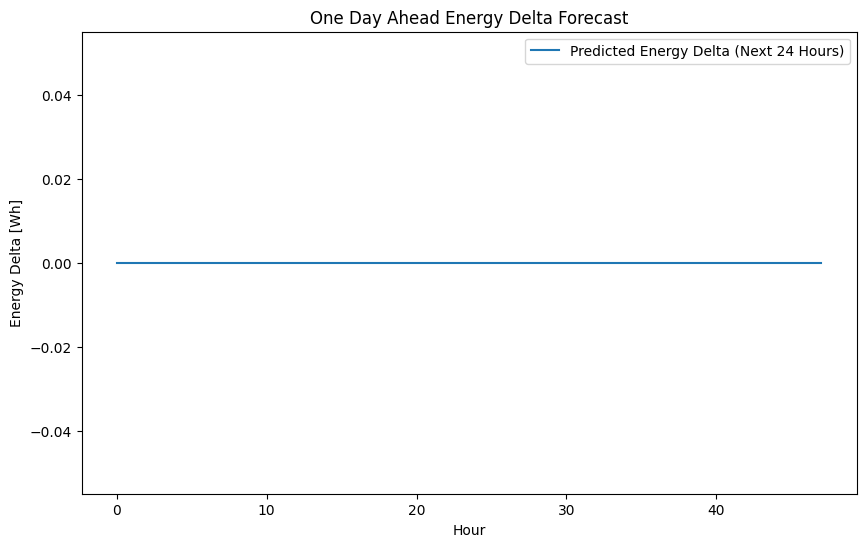

In [ ]:
import matplotlib.pyplot as plt

# Plot the predicted energy delta for the next day (24 hours)
plt.figure(figsize=(10, 6))
plt.plot(predictions_scaled_back, label="Predicted Energy Delta (Next 24 Hours)")
plt.title("One Day Ahead Energy Delta Forecast")
plt.xlabel("Hour")
plt.ylabel("Energy Delta [Wh]")
plt.legend()
plt.show()
